In [1]:
import torch
import torch.nn as nn

In [2]:
import pickle as pk

In [3]:
class DeepFM(nn.Module):
    
    def __init__(self, num_of_users, num_of_times, num_of_locs, rank=8, latent_dim=64):
        
        super(DeepFM, self).__init__()
        
        self.num_of_users = num_of_users
        self.num_of_times = num_of_times
        self.num_of_locs = num_of_locs
        self.rank = rank
        self.latent_dim = latent_dim
        
        self.user_embedding = nn.Embedding(num_of_users, rank * latent_dim)
        self.time_embedding = nn.Embedding(num_of_times, rank * latent_dim)
        
        self.user_linear_weights = nn.Embedding(num_of_users, latent_dim)
        self.time_linear_weights = nn.Embedding(num_of_times, latent_dim)
        
        self.output_softmax = nn.Sequential(
            nn.Linear(latent_dim, (latent_dim + num_of_locs) // 2),
            nn.LeakyReLU(),
            nn.Linear((latent_dim + num_of_locs) // 2, num_of_locs),
        )
        
        self.criteria = nn.CrossEntropyLoss(reduction='sum')
        
    def predict(self, x_u, x_t):
        embed_u = self.user_embedding(x_u).view(-1, 1, self.rank)
        embed_t = self.time_embedding(x_t).view(-1, self.rank, 1)
        interact_term = torch.bmm(embed_u, embed_t).view(-1, self.latent_dim)
        linear_term = self.user_linear_weights(x_u) + self.time_linear_weights(x_t)
        return self.output_softmax(interact_term + linear_term)
    
    def predict_prob(self, x_u, x_t):
        return nn.functional.softmax(self.predict(x_u, x_t), dim=-1)
        
    def forward(self, x_u, x_t, y_l):
        return self.criteria(self.predict(x_u, x_t), y_l)

In [4]:
data = pk.load(open('./data_numpy.pk', 'rb'))

In [5]:
data = torch.LongTensor(data).cuda()

In [6]:
num_of_users = torch.max(data[:, 0]).item() + 1
num_of_times = torch.max(data[:, 1]).item() + 1
num_of_locs = torch.max(data[:, 2]).item() + 1

In [7]:
print(num_of_users, num_of_times, num_of_locs)

1000 7344 1961


In [8]:
deepfm = DeepFM(num_of_users, num_of_times, num_of_locs, rank=4, latent_dim=64).cuda()

In [9]:
optimizer = torch.optim.Adam(deepfm.parameters(), lr=1e-3)
optimizer_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

In [10]:
data.shape[0]

427620

In [11]:
data_size = data.shape[0]
batch_size = 64

for it in range(1, 101):
    avg_loss = 0.0
    optimizer_scheduler.step()
    optimizer.zero_grad()
    data = data[torch.randperm(data_size)]
    
    for i in range(0, data_size, batch_size):
        x_u = data[i: i + batch_size, 0]
        x_t = data[i: i + batch_size, 1]
        y_l = data[i: i + batch_size, 2]
        loss = deepfm(x_u, x_t, y_l)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        avg_loss += loss.item()
        print('Iteration {:04d}, {:.1f}% avg_loss={:.4f}'.format(it, 100.0 * (i + batch_size) / data_size, avg_loss / (i + batch_size)), end='\r')
        
    print()

Iteration 0001, 100.0% avg_loss=3.6816
Iteration 0002, 100.0% avg_loss=2.0612
Iteration 0003, 100.0% avg_loss=1.5778
Iteration 0004, 100.0% avg_loss=1.2649
Iteration 0005, 100.0% avg_loss=1.0263
Iteration 0006, 100.0% avg_loss=0.6580
Iteration 0007, 100.0% avg_loss=0.5397
Iteration 0008, 100.0% avg_loss=0.4714
Iteration 0009, 100.0% avg_loss=0.4257
Iteration 0010, 100.0% avg_loss=0.3963
Iteration 0011, 100.0% avg_loss=0.2912
Iteration 0012, 100.0% avg_loss=0.2679
Iteration 0013, 100.0% avg_loss=0.2609
Iteration 0014, 100.0% avg_loss=0.2554
Iteration 0015, 100.0% avg_loss=0.2519
Iteration 0016, 100.0% avg_loss=0.2038
Iteration 0017, 100.0% avg_loss=0.1957
Iteration 0018, 100.0% avg_loss=0.1936
Iteration 0019, 100.0% avg_loss=0.1922
Iteration 0020, 100.0% avg_loss=0.1913
Iteration 0021, 100.0% avg_loss=0.1656
Iteration 0022, 100.0% avg_loss=0.1631
Iteration 0023, 100.0% avg_loss=0.1623
Iteration 0024, 100.0% avg_loss=0.1617
Iteration 0025, 100.0% avg_loss=0.1614
Iteration 0026, 100.0% av

In [12]:
torch.save(deepfm, 'deepfm_rank{}_latent{}.pytorch'.format(4, 64))

/home/fan/anaconda3/envs/py3/lib/python3.6/site-packages/torch/serialization.py:241: UserWarning: Couldn't retrieve source code for container of type DeepFM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [13]:
data_np = data.cpu().numpy()

In [14]:
import numpy as np

In [15]:
test_data_u = torch.LongTensor([0] * 1000).cuda()
test_data_t = torch.LongTensor(range(1000)).cuda()

In [16]:
with torch.no_grad():
    prob = deepfm.predict_prob(test_data_u, test_data_t).cpu().numpy()

In [17]:
prob.shape

(1000, 1961)

In [18]:
max_locs = np.argmax(prob, axis=1)

In [19]:
import matplotlib.pyplot as plt

In [20]:
import seaborn as sns

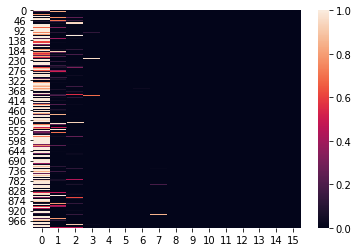

In [25]:
sns.heatmap(prob[:, :16])

In [22]:
max_locs

array([   0,    0,    0,    0,    0, 1272,    0,    1,    0,    0,    1,
          3,  446,    0,    0,    0, 1140,   93,    0,    0,    1,    0,
        418,    0,    2, 1571,    0,    0,    0,    1,    0,    2,    0,
       1139,    1,    1,    0,    0,    0,    0,    0,    0,    0,    2,
          0,    1,    0,    0,    1,    0,    0,  252,    0, 1251,    0,
          1,    0, 1069,    2,    0,    0,    0,    2,  214,    0,  669,
          0,    0,    0,    0,    0,    0,    0,    1,    0, 1716,    0,
          0,    0,    0,    0,    0,    0,    1,  187,    0,    2,    0,
          0,    0,    0,    1,    0,    0,    0,    0,  483,    0,    0,
          0,    0,    0,    1,    0,    0,    0, 1582, 1138,    0,    0,
          1,    0,    0,    0,    1, 1108,    0,    2,    3,    0,    0,
          1,    0,    0,    0,    2,    0,    0,    0,    0,    0,    1,
          0,    0,    0,    0,    0,    0,  267,    1,    0,    1,    2,
          0,    1,    0,  978,    0,    0,    0,   

In [33]:
data_np[np.where(data_np[:, 0] == 0)]

array([[   0, 4777,    0],
       [   0, 6513,    0],
       [   0, 6514,    0],
       [   0, 1453,    0],
       [   0, 4824,    2],
       [   0, 5456,    2],
       [   0, 1437,    0],
       [   0, 1747,    1],
       [   0, 4930,    0],
       [   0, 2268,    0],
       [   0, 5458,    0],
       [   0, 5357,    0],
       [   0, 2632,    0],
       [   0, 7085,    2],
       [   0, 4931,    0],
       [   0, 1653,    1],
       [   0,  566,    0],
       [   0,  271,    0],
       [   0, 4743,    0],
       [   0, 6512,    0],
       [   0,  694,    0],
       [   0, 4916,    0],
       [   0, 7265,    0],
       [   0, 4747,    0],
       [   0,  424,    0],
       [   0,  566,    1],
       [   0, 1749,    0],
       [   0, 7083,    0],
       [   0, 5269,    0],
       [   0,  837,    2],
       [   0, 1910,    0],
       [   0, 2201,    0],
       [   0, 6312,    0],
       [   0, 1374,    0],
       [   0, 1747,    1],
       [   0, 1765,    3],
       [   0, 1381,    0],
 